In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from jax import lax

In [2]:
# Function to calculate the equilibrium distribution


def equilibrium(rho, u):
    cdot3u = 3 * jnp.einsum('ai,axy->ixy', c, u)    # This is 3*c*u
    usq = jnp.einsum('axy->xy', u*u)                # This is u^2
    wrho=jnp.einsum('i,xy->ixy', w, rho)            
    feq = wrho * (1 + cdot3u*(1 + 0.5*cdot3u) - 1.5*usq[np.newaxis,:,:])
    return feq
# Define the streaming function
def Stream(g, c):
    def body(i, g):
        shift = (c.T[i][0], c.T[i][1])
        g = g.at[i].set(jnp.roll(g[i], shift=shift, axis=(0, 1)))
        return g

    g = lax.fori_loop(1, 9, body, g)
    return g
# Define the scattering function
def Collide(g):
    rho = jnp.einsum('ijk->jk',g)
    u = jnp.einsum('ai,ixy->axy',c,g)/rho
    feq = equilibrium(rho,u)
    g = g + omega*(feq-g)
    return g

In [3]:
# dimensions of the 2D lattice and the Lattice parameters
NX=60 #int(input("nx = "))
NY=40 #int(input("ny = "))
# simulation parameters
scale  = 1               # set simulation size
#NX     = 32*scale        # domain size
#NY     = NX
NSTEPS = 200*scale*scale # number of simulation time steps
NMSG   = 50*scale*scale  # show messages every NMSG time steps
vis    = False           # show visualisation; set to False for performance measurements
NVIS   = NMSG            # show visualisation every NVIS time steps
omega  = 1.5
tau    = 1/omega               # relaxation time
u_max  = 0.1/scale      # maximum velocity
nu     = (1/omega-1/2)/3     # kinematic shear viscosity
rho0   = 1.0               # rest density
#Re     = NX*u_max/nu     # Reynolds number; not used in the simulation itself
#
# Define the wights and channel velocities
w = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]) # weights
c = jnp.array([[0, 1, 0, -1,  0, 1, -1, -1,  1],  # velocities, x components
              [0, 0, 1,  0, -1, 1,  1, -1, -1]]) # velocities, y components
#
# Define the gridpoints
x = jnp.arange(NX)+0.5    # the position of the points is half-ways in the interval
y = jnp.arange(NY)+0.5
X,Y = jnp.meshgrid(x,y)
# Initialize the density with 1.0 and the velocity with a sinusoidal
rho=jnp.ones((NX,NY))
n = 1           # multiples of the basic wavenumber try to play with n
k = 2*jnp.pi*n/NY  # Wavenumbers
u = jnp.array([u_max*jnp.sin(k*Y.T),jnp.zeros((NX,NY))])
f = equilibrium(rho,u) # create a local equilibrium initial condition. Note the term "local" it will decay due to viscosity

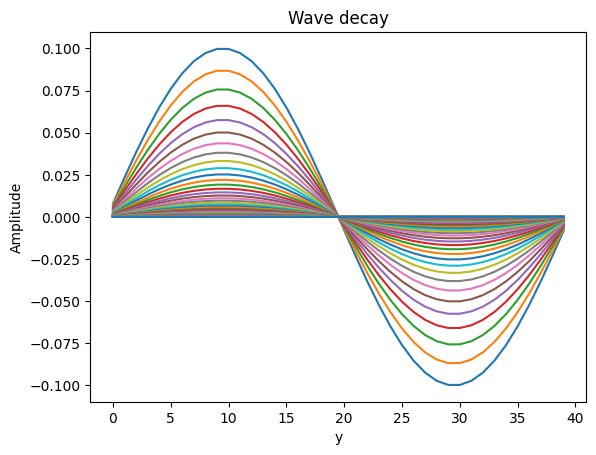

In [4]:
amp=jnp.array(u[0,NX//2,NY//8]) # The amplitud of u in time
#
fig, ax = plt.subplots()
ax.plot(u[0,NX//2,:])
ax.set_title('Wave decay')
ax.set_xlabel('y')
ax.set_ylabel('Amplitude')
for n in range(1,10001):
    f = Stream(f, c)
    f = Collide(f)
    if n%100==0:
        #Tmeasure=np.append(Tmeasure,np.array(time))
        u = jnp.einsum('ai,ixy->axy',c,f)/rho  
        ax.plot(u[0,NX//2,:])
        amp=jnp.append(amp,u[0,NX//2,NY//8])
#    

Text(0, 0.5, 'Amplitude')

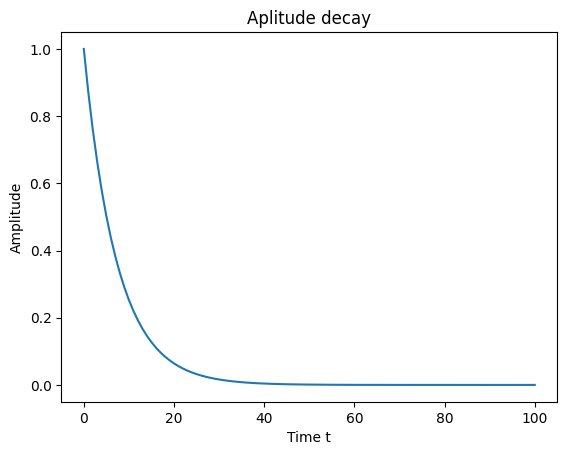

In [5]:
# Plotting the amplitude decay
fig, ax = plt.subplots()
ax.plot(amp/amp[0])
ax.set_title('Aplitude decay')
ax.set_xlabel('Time t')
ax.set_ylabel('Amplitude')

In [ ]:
import numpy as np
import jax.numpy as jnp

def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(5.0)
print(selu(x))

[0.        1.05      2.1       3.1499999 4.2      ]


In [ ]:
from jax import random

key = random.key(1701)
x = random.normal(key, (1_000_000,))
%timeit selu(x).block_until_ready()

3.43 ms ± 544 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from jax import jit

selu_jit = jit(selu)
_ = selu_jit(x)  # compiles on first call
%timeit selu_jit(x).block_until_ready()

195 μs ± 12.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
from jax import grad

def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.19661197 0.10499357]


In [ ]:
def first_finite_differences(f, x, eps=1E-3):
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])

print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1964569  0.10502338]
